<hr>

<table style="width:100%">
  <tr>
    <th><img align="center" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/UNAL_Aplicación_Medell%C3%ADn.svg/1280px-UNAL_Aplicación_Medell%C3%ADn.svg.png" width="300"/></th>
    <th><img align="center" src="http://www.redttu.edu.co/es/wp-content/uploads/2016/01/itm.png" width="300"/> </th> 
    <th><img align="center" src="https://www.cienciasdelaadministracion.uns.edu.ar/wp-content/themes/enlighten-pro/images/logo-uns-horizontal.png" width="300"/></th>
  </tr>
</table>


<hr>

#### Pedro Atencio Ortiz - 2019 (pedroatencio@itm.edu.co)


# 3. Red Neuronal y Backpropagation (descenso del gradiente generalizado)

En este notebook abordaremos los siguientes tópicos:

- Notación.
- Forward propagation.
- Backpropagation.
- Ejemplo completo (XOR)
- Ejemplo con dataset sintético.
- Errores y funciones de activación.

In [33]:
# Funciones utilitarias

import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_data(data_type, noise=0.2):
    
    np.random.seed(0)
    if data_type == 'moons':
        X, Y = datasets.make_moons(200, noise=noise)
    elif data_type == 'circles':
        X, Y = sklearn.datasets.make_circles(200, noise=noise)
    elif data_type == 'blobs':
        X, Y = sklearn.datasets.make_blobs(centers=2, cluster_std=noise)
    return X, Y

def visualize_lr(W1, b1, W2, b2, W3, b3, X, Y):
    X = np.copy(X.T)
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict_multilayer(W1,b1,W2,b2,W3,b3,np.c_[xx.ravel(), yy.ravel()].T)

    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
    
    color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

<hr>

## 3.1. Notación

Con el objetivo de poder trabajar un mecanismo general de entrenamiento de una secuencia de regresores, llamados de ahora en adelante red neuronal, necesitamos primero definir una notación genérica para el dataset, parámetros de la red neuronal y resultados de esta. Analicemos la siguiente figura:

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/layered_regresor_general.png?raw=true" width="500"/>

Nótese que tanto el conjunto de datos de entrada $X$ como los pesos $W$ y demás elementos pueden definirse como matrices y arreglos, que al ser operados mediante vectorization / broadcasting, nos permiten simplificar el proceso de construcción y cálculo.

A partir de lo anterior, definamos los siguientes elementos:

- Sea $[X,Y]$ un dataset supervisado que contiene $m$ ejemplos, cada uno de dimensión $n_x$, entonces $X_{(n_x, m)}$, $Y_{(1, m)}$.

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/dataset.png?raw=true" width="500"/>

- Sea $l$ el número de capas de la red y $n^{[i]}$ el numero de neuronas de la capa $i$.
- Sea $W^{[i]}$ la matriz de pesos de la capa $i$, entonces $W^{[i]}_{(n^{[i]},n^{[i-1]})}$. Nótese que esto es equivalente a definir $W$ de forma traspuesta.
- Sea $b^{[i]}$ el arreglo de bias de la capa $i$, entonces $b^{[i]}_{(n^{[i]}, 1)}$.
- Sea $Z^{[i]}$ la activacion lineal o entrada de la capa $i$, entonces $Z^{[i]}_{(n^{[i]}, m)}$
- Sea $A^{[i]}$ la salida de la capa $i$, entonces $A^{[i]}_{(n^{[i]}, m)}$. Nótese que $A^{[0]} = X$

<hr>

## 3.2. Forward Propagation

Este es el proceso de computar la salida de la red a partir de la entrada, en otras palabras, calcular las predicciones para un conjunto de entrada.

Este proceso se utiliza principalmente en dos momentos:

1. En el entrenamiento de la red.
2. Una vez entrenada, para lanzar predicciones.

Se define de forma general mediante las siguientes instrucciones:

<br>

<font size=3>
$
\\
para(i:1 \rightarrow l)\{
\\
\hspace{10mm} Z^{[i]} = W^{[i]}.A^{[i-1]} + b^{[i]}
\\
\hspace{10mm} A^{[i]} = f(A^{[i]})
\\
\}
$
</font>

Implementemos lo anterior para el caso del regresor en cadena que utilizamos para el XOR.

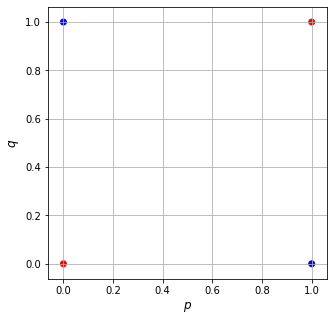

In [2]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0, 1, 1, 0]])

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.grid()
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel(r'$q$', fontsize=12)

plt.show()

X = X.T #Transponemos X para que quede de dimension (nx, m)

In [9]:
#Definamos los W en cada caso
np.random.seed(2)
W1 = np.random.random([2,2])
b1 = np.zeros([2,1])

W2 = np.random.random([3,2])
b2 = np.zeros([3,1])

W3 = np.random.random([1,3])
b3 = np.zeros([1,1])

In [10]:
print(W1,W2)
print(X)

[[0.4359949  0.02592623]
 [0.54966248 0.43532239]] [[0.4203678  0.33033482]
 [0.20464863 0.61927097]
 [0.29965467 0.26682728]]
[[0 0 1 1]
 [0 1 0 1]]


In [5]:
def sigmoid(Z):
    A = 1. / (1. + np.exp(-Z))  
    return A

In [11]:
#Feed-Forward: implementamos el ciclo explicitamente
Z1 = np.dot(W1,X) + b1
A1 = sigmoid(Z1)
Z2 = np.dot(W2, A1) + b2
A2 = sigmoid(Z2)
Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

print("Salida de la red para 4 datos: ", A3)

Salida de la red para 4 datos:  [[0.6820576  0.68534912 0.68824311 0.69105156]]


In [16]:
#Este proceso se puede automatizar utilizando alguna estructura de datos, por ejemplo, diccionarios

layers = {"layer1":{"W":W1, "b":b1}, "layer2":{"W":W2, "b":b2}, "layer3":{"W":W3, "b":b3}} #parametros de la red neuronal
pred = {"layer0":{"A":X}} #diccionario para guardar los Z y A en cada iteracion del feed-forward

for i in range(1, len(layers)+1):
    layer = layers["layer"+str(i)]
    pred["layer"+str(i)] = {}
    
    #Recuperamos datos de la iteracion anterior
    W = layer["W"]
    b = layer["b"]
    A_prev = pred["layer"+str(i-1)]["A"]
    
    #Feed-forward
    Z = np.dot(W, A_prev) + b
    A = sigmoid(Z)
    
    #Salvamos los datos de esta iteracion
    pred["layer"+str(i)]["Z"] = Z
    pred["layer"+str(i)]["A"] = A

print("Salida de la red para 4 datos: ", pred["layer3"]["A"])

print(pred["layer2"]["Z"].shape, pred["layer1"]["A"])

Salida de la red para 4 datos:  [[0.6820576  0.68534912 0.68824311 0.69105156]]
(3, 4) [[0.5        0.50648119 0.60730428 0.61346982]
 [0.5        0.60714389 0.63405728 0.7280962 ]]


<hr>

## 3.3. Backpropagation + update

Backpropagation o retro-propagación del error consiste en aplicar el descenso del gradiente sobre una red neuronal con una __arquitectura arbitraria__, utilizando para ello la regla de la cadena sobre el gráfo de cómputo de la red para obtener las derivadas parciales de cada parámetro a partir del error en la salida.

<img align="center" src="https://github.com/psatencio/intro_keras/blob/master/figures/backprop_general.png?raw=true" width="500"/>

Se define de forma general mediante las siguientes instrucciones:

<br>

$
\\
para(i:l \rightarrow 1)\{
\\
\hspace{10mm} dZ^{[i]} = \left\{\begin{matrix} si(i==l) & A^{[i]} - Y \\ sino & W^{[i+1]T}.dZ^{[i+1]} * f'({Z^{[i]}})\end{matrix}\right.
\\
\hspace{10mm} dW^{[i]} = \frac{(dZ^{[i]}.A^{[i-1]T})}{m}
\\
\hspace{10mm} db^{[i]} = \frac{\sum{(dZ^{[i]})}}{m}
\\
\}
$

<hr>

### Ciclo completo

Finalmente, el proceso completo de entrenamiento de una red consiste en la secuencia __forward-propagation $\rightarrow$ back-propagation $\rightarrow$ actualizacion__:

<br>

<font size=3>
$
\\
para(i:1 \rightarrow l)\{
\\
\hspace{10mm} Z^{[i]} = W^{[i]}.A^{[i-1]} + b^{[i]}
\\
\hspace{10mm} A^{[i]} = f(A^{[i]})
\\
\}
$
<br>
<br>
$
\\
para(i:l \rightarrow 1)\{
\\
\hspace{10mm} dZ^{[i]} = \left\{\begin{matrix} si(i==l) & A^{[i]} - Y \\ sino & W^{[i+1]T}.dZ^{[i+1]} * f'({Z^{[i]}})\end{matrix}\right.
\\
\hspace{10mm} dW^{[i]} = \frac{(dZ^{[i]}.A^{[i-1]T})}{m}
\\
\hspace{10mm} db^{[i]} = \frac{\sum{(dZ^{[i]})}}{m}
\\
\}
$
<br>
<br>
$
\\
para(i:1 \rightarrow l)\{
\\
\hspace{10mm} W^{[i]} = W^{[i]} - \alpha dW^{[i]}
\\
\hspace{10mm} b^{[i]} = b^{[i]} - \alpha db^{[i]}
\\
\}
$
</font>

<hr>

## 3.4. Ejemplo completo: XOR

Implementemos todo el proceso de entrenamiento para el problema del XOR y utilizando las definiciones anteriores.

In [173]:
def sigmoid(Z):
    A = 1. / (1. + np.exp(-Z))  
    return A

def d_sigmoid(Z):
    Ap = sigmoid(Z)*(1-sigmoid(Z))
    return Ap

def tanh(Z):
    return (np.exp(Z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def tanh_p(Z):
    return 1 - tanh(Z)**2

def loss(Y, A):
    return -(Y * np.log(A) + (1-Y) * np.log(1-A))

def cost(l):
    return np.mean(l)

def activation(Z, func='sigmoid'):
    if(func == 'sigmoid'):
        A = 1. / (1. + np.exp(-Z))  
    elif(func == 'tanh'):
        A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    
    return A

def activation_d(Z, func='sigmoid'):
    if(func == 'sigmoid'):
        A = activation(Z)*(1-activation(Z))  
    elif(func == 'tanh'):
        A = 1 - activation(Z,func)**2
    
    return A

In [174]:
#Dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
Y = np.array([[0, 1, 1, 0]])
X = X.T

m = len(X)

In [175]:
np.random.seed(2)
W1 = np.random.random([5,2])
b1 = np.zeros([5,1])

W2 = np.random.random([3,5])
b2 = np.zeros([3,1])

W3 = np.random.random([1,3])
b3 = np.zeros([1,1])


Z1 = np.dot(W1, X) + b1
A1 = sigmoid(Z1)
    
Z2 = np.dot(W2, A1) + b2
A2 = sigmoid(Z2)
    
Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

In [217]:
#Parametros de la red
np.random.seed(2)
W1 = np.random.random([10,2])
b1 = np.zeros([10,1])

W2 = np.random.random([3,10])
b2 = np.zeros([3,1])

W3 = np.random.random([1,3])
b3 = np.zeros([1,1])

'''
Parametros de aprendizaje
'''
num_epochs = 10000
learning_rate = 0.007

history = []

for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = np.dot(W1, X) + b1
    A1 = activation(Z1, 'tanh')
    
    Z2 = np.dot(W2, A1) + b2
    A2 = activation(Z2, 'tanh')
    
    Z3 = np.dot(W3, A2) + b3
    A3 = activation(Z3)

    '''
    Backward Propagation
    '''
    dZ3 = A3 - Y
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    dZ2 = np.multiply(np.dot(W3.T, dZ3), activation_d(Z2, 'tanh'))
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), activation_d(Z1, 'tanh'))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    '''
    Actualizacion de parametros
    '''
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    W3 -= learning_rate * dW3
    
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    b3 -= learning_rate * db3

    '''
    Costo
    '''
    J = cost(loss(Y,A3))
    history.append(J)
        
print("parametros actualizados: ", (W1, W2, W3))

parametros actualizados:  (array([[ 0.95879614,  4.8422886 ],
       [ 0.64011265,  0.65136888],
       [ 1.09736973,  0.41053189],
       [ 0.56238752,  0.57777146],
       [ 0.45009869,  1.23110924],
       [ 6.8518495 ,  5.24510117],
       [ 1.77727851,  6.21549492],
       [-0.75789721,  4.87477006],
       [ 3.59416113,  0.59128725],
       [ 5.63524062, -3.09784833]]), array([[ 2.67019621,  0.4550304 ,  1.337519  ,  0.39995311,  0.05348676,
         5.79633251,  4.26281214, -6.97460438, -0.63132773, -7.2916764 ],
       [ 2.84431309,  0.10305337,  0.39389562,  0.11886133, -0.31430231,
         2.07435592,  4.89659075,  2.81455543, -5.03724207,  9.64708949],
       [ 2.22376732,  3.24331559,  3.46620803,  2.96469043,  3.38473576,
         3.25328418, -0.10414202,  3.95417651,  3.75000675,  4.72382267]]), array([[ 3.61635265, -5.61121823,  3.49244989]]))


In [218]:
def predict_multilayer(W1,b1,W2,b2,W3,b3,X):
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    return A3

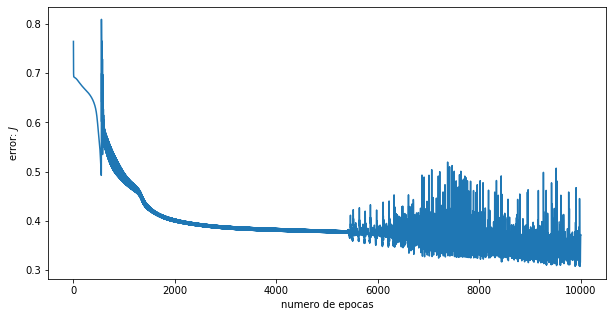

In [219]:
'''
Visualizacion del error por epoca
'''
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,num_epochs-1, num_epochs), history)
plt.xlabel("numero de epocas")
plt.ylabel("error: "+r'$J$')
plt.show()

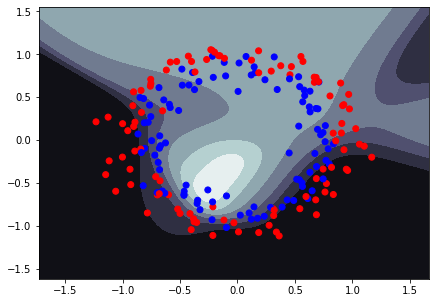

In [220]:
visualize_lr(W1,b1,W2,b2,W3,b3,X,Y)

<hr>

<font size=4>
    
__Trabajemos__: 

Utilicemos lo implementado al momento para clasificar el problema de la siguiente figura y pruebe:

- Pruebe agregando más neuronas en la capa 1.
- Pruebe agregando más capas a la red.
- Pruebe distintas configuraciones $\alpha$.
- Pruebe distintos valores para el número de épocas.

</font>

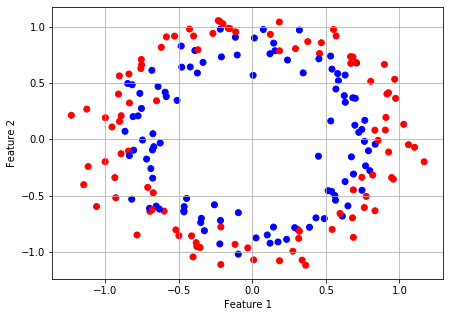

In [200]:
X, Y = generate_data('circles', 0.1)
Y = Y.reshape(1,len(Y))

color = ['blue' if y == 1 else 'red' for y in np.squeeze(Y)] # una lista para darle color a las clases

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], color=color)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()

plt.show()

X = X.T

In [56]:
print(X.shape)

(2, 200)


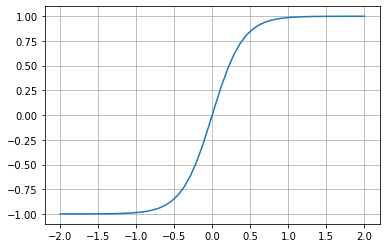

In [151]:
z = np.linspace(-5,5,50)

tanh = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
plt.plot(x,tanh)
plt.grid()

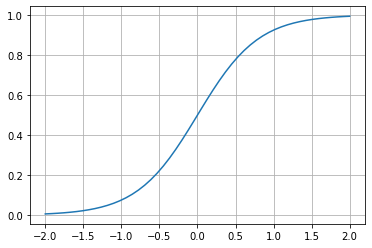

In [152]:
sig = (1)/(1+np.exp(-z))
plt.plot(x,sig)
plt.grid()

In [156]:
zer = np.zeros(50)
relu = np.max(zer,z)
plt.plot(x,relu)
plt.grid()

TypeError: only integer scalar arrays can be converted to a scalar index